In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython import display
from sklearn.preprocessing import minmax_scale
import pickle as pkl
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:

def retrieve_dataset(df, start, end):
    output_df = df.loc[start:end]
    output_df.columns = df.loc[start-1]
    output_df.columns.name = None
    output_df = output_df.set_index('Cycle Nr.', drop=True)
    output_df = output_df.drop(['Time [s]', 'Temp. [°C]'], axis=1)
    return output_df
    # return od600, gfp, rfp

def layoutToDict(layoutName,dataDf ):
    layoutDict = {}
    originalLayoutDf = pd.read_csv(layoutName, sep=',', header=None)
    layoutNp = originalLayoutDf.to_numpy()
    layoutNp = layoutNp.reshape(1,96)[0]
    index_list= list(dataDf.to_dict().keys())
    for count, col in enumerate(index_list):
        layoutDict[col] = layoutNp[count]
    return layoutDict

def reject_outliers(data, m=2):
    data = np.array(data)
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def maxgrowth_data(output_df):
    od600 = retrieve_dataset(output_df, 96, 203) #start should be where title of dataset (e.g. 0d600)
    
    gfp = retrieve_dataset(output_df, 207, 314) #start should be where title of dataset (e.g. 0d600)
    rfp = retrieve_dataset(output_df, 318, 425) #start should be where title of dataset (e.g. 0d600)
    maxValues = od600.max()
    for column in od600.columns:
        od600[column] = pd.to_numeric(od600[column])

        # maxValues, maxValueIndex
    od600max = pd.Series(maxValues, index=od600.columns)
    maxValueIndex = od600.idxmax()
    gfpMax = {}
    rfpMax = {}
    for index, column in zip(maxValueIndex, gfp.columns):
        gfpMax[column] = gfp.loc[index, column]
        rfpMax[column] = rfp.loc[index, column]


    gfpMax = pd.Series(gfpMax)
    rfpMax = pd.Series(rfpMax)

    maxValueIndex = od600.idxmax()
    return od600max, gfpMax, rfpMax, maxValueIndex

def IndexConcDict(ATC_layoutName,morphogen_layoutName,referenceDf):

    #get names of layouts
    ATC_layoutDict = layoutToDict(ATC_layoutName,referenceDf)
    morphogen_layoutDict = layoutToDict(morphogen_layoutName,referenceDf)
    # print(morphogen_layoutDict)
    #storage arrays
    ATC_layout_index = []
    highATC_morphogen_layoutDict = {}

    #loop over df of fixed molecule and select desired concentration
    for k,v in ATC_layoutDict.items():
        if v == '-0.5': #dose responses will be fixed for this concentration (e.g High ATC)
            ATC_layout_index.append(k)
    #loop over variable molecule #e.g OC14 or HSL
    for k,v in morphogen_layoutDict.items():
        if k in ATC_layout_index:
            if v == 'ZERO':
                highATC_morphogen_layoutDict[k] = -5
            else:
                highATC_morphogen_layoutDict[k] = v
    

    highATC_morphogen_layoutDict = dict(sorted(highATC_morphogen_layoutDict.items(), key=lambda item: float(item[1])))
    return highATC_morphogen_layoutDict

def substractEmptyCells(od600,gfp,rfp ,layoutDict):
    #find empty cells 
    emptyod600 = []
    emptygfp = []
    emptyrfp = []
    for key, value in layoutDict.items():
        if value == 'empty':
            emptyod600.append(od600[key])
            emptygfp.append(gfp[key])
            emptyrfp.append(rfp[key])


    #substract mean of empty cells from all cells
    #make sure to remove outliers
    od600 = od600 - np.amin(emptyod600) + 1e-08
    gfp = gfp - np.amin(emptygfp)
    rfp = rfp - np.amin(emptyrfp)
    return od600, gfp, rfp


def curveTransfer(gfpReplicates, rfpReplicates):
    gfpVmax, rfpVmax = np.mean(gfpReplicates[10e0]), np.mean(rfpReplicates[10e-3])

    gfpTransfered = pd.DataFrame(columns=gfpReplicates.columns)
    rfpTransfered = pd.DataFrame(columns=rfpReplicates.columns)
    for index, row in gfpReplicates.iterrows():
        arr = pd.Series(minmax_scale(row, feature_range=(1,gfpVmax)), index=gfpReplicates.columns)
        gfpTransfered = gfpTransfered.append(arr, ignore_index=True)

    for index, row in rfpReplicates.iterrows():
        arr = pd.Series(minmax_scale(row, feature_range=(1,rfpVmax)), index=rfpReplicates.columns)
        rfpTransfered = rfpTransfered.append(arr, ignore_index=True)

    return gfpTransfered, rfpTransfered

    #substract mean of empty cells from all cells
    #make sure to remove outliers
    od600 = od600 - np.mean(reject_outliers(emptyod600))
    gfp = gfp - np.mean(reject_outliers(emptygfp))
    rfp = rfp - np.mean(reject_outliers(emptyrfp))
    return od600, gfp, rfp


def plotDoseResponsevsData(inducer, rfpExp_list, gfpExp_list, semRed, semGreen,pad=0.01, inducerName='OC14'):
    fig,ax = plt.subplots()

    ax.plot(inducer,rfpExp_list,label='RFP', c='red')
    ax.scatter(inducer,rfpExp_list, c='red')
    ax.errorbar(inducer,rfpExp_list,yerr=semRed,c='red',fmt='o')
    ax.legend(loc='center left') #upper right
    ax.set_ylabel('RFP / ($A_{600}$ $RFP_{basal})$')
    ax.set_xscale('log')


    ax2=ax.twinx()
    ax2.plot(inducer,gfpExp_list,label='GFP', c='green')
    ax2.scatter(inducer,gfpExp_list, c='green')
    ax2.errorbar(inducer,gfpExp_list,yerr=semGreen,c='green',fmt='o')
    ax2.legend(loc='center right') #upper left
    ax2.set_ylabel('GFP / ($A_{600}$ $GFP_{basal})$')
    ax.set_xscale('log')

    ax.set_xlabel(f'{inducerName} concentration (µM)')

    plt.show()


Labelling some past liquid culture experiments for Martina
==========================================================

Hi Martiiii hope this is good for you!

Here are a few subcircuits that I tested.

### IMPORTANT:
All of the numbers are to be taken as 10**(csvValue). Absolute zero is a string ("ZERO")

Each plate has two inducers: 1. ATC, 2. either HSL or pC.

Two experiments in Subcircuit A also have a column of IPTG - so these have another csv for IPTG setup.

lmk if you have any questions!!

Subcircuit #1:
-------------
<img src="subcircuitFigures/Subcircuit1.png" width="500" height="200">


### Plasmid Contents:
pCOLA-nodeA-pC-tacI  : nodeA
pCDF-nodeBdel-$\Delta$ lacI  : nodeB without diffuser enzyme
pET-nodeC   : node C
pCC1-rpaR-Q168R   : control cassete

### Experiments:
E20201120A: Data missing (it's on the old TECAN most likely - lmk if you need it)  
E20201123B  
E20201124A  
E20201125C  
E20201126A  




In [4]:
import os

# vvvvvvv CHANGE ME vvvvvvv
current_path = ''
# ^^^^^^^ CHANGE ME ^^^^^^^


################
# SUBCIRCUIT A #
################

# data csvs
subcircuit1_excelpath = os.path.join(current_path, 'input/liquid_culture/Jure_OD600_GFP25_mCherry30_18hr_20230421_095956.xlsx')#



In [5]:

def retrieve_dataset(df, start, end):
    output_df = df.loc[start:end]
    output_df.columns = df.loc[start-1]
    output_df.columns.name = None
    output_df = output_df.set_index('Cycle Nr.', drop=True)
    output_df = output_df.drop(['Time [s]', 'Temp. [°C]'], axis=1)
    return output_df
    # return od600, gfp, rfp



def maxgrowth_data(output_df):
    od600 = retrieve_dataset(output_df, 88, 151) #start should be where title of dataset (e.g. 0d600)
    
    gfp = retrieve_dataset(output_df, 155, 218) #start should be where title of dataset (e.g. 0d600)
    rfp = retrieve_dataset(output_df, 222, 285) #start should be where title of dataset (e.g. 0d600)
    maxValues = od600.max()
    for column in od600.columns:
        od600[column] = pd.to_numeric(od600[column])

        # maxValues, maxValueIndex
    od600max = pd.Series(maxValues, index=od600.columns)
    maxValueIndex = od600.idxmax()
    gfpMax = {}
    rfpMax = {}
    for index, column in zip(maxValueIndex, gfp.columns):
        gfpMax[column] = gfp.loc['64', column]
        rfpMax[column] = rfp.loc['64', column]



    gfpMax = pd.Series(gfpMax)
    rfpMax = pd.Series(rfpMax)

    maxValueIndex = od600.idxmax()
    return od600max, gfpMax, rfpMax, maxValueIndex

def plotDoseResponsevsData(inducer, rfpExp_list, gfpExp_list, semRed, semGreen,pad=0.01, inducerName='OC14'):
    fig,ax = plt.subplots()

    ax.plot(inducer,rfpExp_list,label='RFP', c='red')
    ax.scatter(inducer,rfpExp_list, c='red')
    ax.errorbar(inducer,rfpExp_list,yerr=semRed,c='red',fmt='o')
    ax.legend(loc='center left') #upper right
    ax.set_ylabel('RFP / ($A_{600}$ $RFP_{basal})$')
    ax.set_xscale('log')


    ax2=ax.twinx()
    ax2.plot(inducer,gfpExp_list,label='GFP', c='green')
    ax2.scatter(inducer,gfpExp_list, c='green')
    ax2.errorbar(inducer,gfpExp_list,yerr=semGreen,c='green',fmt='o')
    ax2.legend(loc='center right') #upper left
    ax2.set_ylabel('GFP / ($A_{600}$ $GFP_{basal})$')
    ax.set_xscale('log')

    ax.set_xlabel(f'{inducerName} concentration (µM)')

    plt.show()

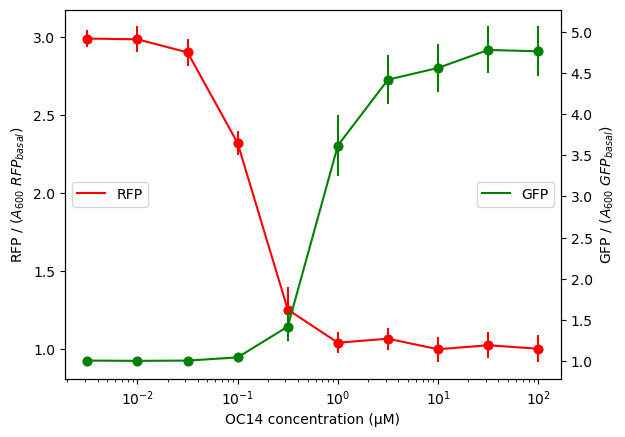

In [9]:
OC14_list = np.logspace(-2.5,2,10)
gfpReplicates = pd.DataFrame()
rfpReplicates = pd.DataFrame()


output_df = pd.read_excel(subcircuit1_excelpath)

#find maximum od values
od600Max, gfpMax, rfpMax, maxValueIndex = maxgrowth_data(output_df)
replicate_indices = [(['B11', 'B10', 'B9', 'B8', 'B7', 'B6', 'B5', 'B4', 'B3', 'B2'],['C11', 'C10', 'C9', 'C8', 'C7', 'C6', 'C5', 'C4', 'C3', 'C2']),
                        (['D11', 'D10', 'D9', 'D8', 'D7', 'D6', 'D5', 'D4', 'D3', 'D2'],['E11', 'E10', 'E9', 'E8', 'E7', 'E6', 'E5', 'E4', 'E3', 'E2']),
                        (['F11', 'F10', 'F9', 'F8', 'F7', 'F6', 'F5', 'F4', 'F3', 'F2'],['G11', 'G10', 'G9', 'G8', 'G7', 'G6', 'G5', 'G4', 'G3', 'G2'])]
#relativise to od600
for fluorophoreData, fluorophoreName in zip([gfpMax, rfpMax], ['GFP', 'RFP']):
    # relFp = fluorophoreData/od600Max

    relFp = fluorophoreData


    for repIndex in replicate_indices:
        rep = (relFp[repIndex[0]], relFp[repIndex[1]])

        intraexperiment_mean = pd.Series(np.mean(np.stack(rep), axis=0))
        if fluorophoreName == 'GFP':
            gfpReplicates = gfpReplicates.append(intraexperiment_mean, ignore_index=True)
        elif fluorophoreName == 'RFP':
            rfpReplicates = rfpReplicates.append(intraexperiment_mean, ignore_index=True)



#define columns as OC14 concentrations
gfpReplicates.columns = OC14_list
rfpReplicates.columns = OC14_list

#average interexperimental replicates 
meanGfp = gfpReplicates.mean(axis=0)
# meanGfp = np.log(meanGfp)
import scipy
# meanGfp_logit = scipy.special.logit(meanGfp)
meanGfp_basal = meanGfp/np.amin(meanGfp)
# print(meanGfp_basal)

stdGfp = gfpReplicates.std(axis=0)
stdGfp_basal = stdGfp/np.amin(meanGfp)

meanRfp = rfpReplicates.mean(axis=0)
meanRfp_basal = meanRfp/np.amin(meanRfp)
stdRfp = rfpReplicates.std(axis=0)
stdRfp_basal = stdRfp/np.amin(meanRfp)

plotDoseResponsevsData(OC14_list, meanRfp_basal, meanGfp_basal, stdRfp_basal ,stdGfp_basal, inducerName='OC14') 


In [12]:
meanGfp_logit = scipy.special.logit(meanGfp)
meanGfp_logit = scipy.special.logit(np.arange(10))
meanGfp_logit, meanGfp

(array([-inf,  inf,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan]),
 0.003162       219.333333
 0.010000       218.666667
 0.031623       219.333333
 0.100000       227.833333
 0.316228       309.833333
 1.000000       791.666667
 3.162278       966.833333
 10.000000      998.166667
 31.622777     1046.000000
 100.000000    1042.333333
 dtype: float64)

[219.33333333,
 218.66666667,
 219.33333333,
 227.83333333,
 309.83333333,
 791.66666667,
 966.83333333,
 998.16666667,
 1046.0,
 1042.33333333]

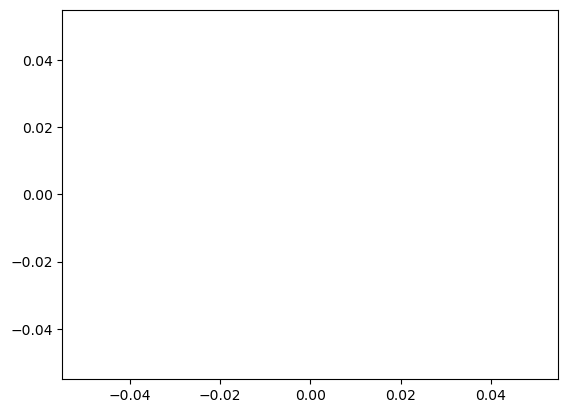

In [28]:

x =[ 219.33333333,  218.66666667,  219.33333333,  227.83333333,
        309.83333333,  791.66666667,  966.83333333,  998.16666667,
       1046.        , 1042.33333333]
y = scipy.special.logit(x)
plt.plot(x, y)
x

In [6]:
dataDict = {}
dataDict['OC14'] = OC14_list
dataDict['mean_gfp'] = meanGfp_basal
dataDict['std_gfp'] = stdGfp_basal
dataDict['mean_rfp'] = meanRfp_basal
dataDict['std_rfp'] = stdRfp_basal
pkl.dump(dataDict, open('input/liquid_culture/curatedData/Jure_subcircuit1_circuit14_doseResponseOC14_0.5ATC_nonlinearGFP.pkl', 'wb'))


Subcircuit #4
-------------
<img src="subcircuitFigures/Subcircuit4.png" width="500" height="200">


### Plasmid Contents:
p15a-hpv0t  
pCDF-B-pC-$\Delta$ cI   
pET-nodeC  
pCC1-rpaR-Q168R  


### Experiments:
E20201203A  
E20201204A  
E20201207A  
E20201208A  
E20201209A  
E20201216A  

In [137]:
################
# SUBCIRCUIT B #
################

E20201203A = os.path.join(current_path, 'data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201204_111319.xlsx')
E20201204A = os.path.join(current_path, 'data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201205_114446.xlsx')
E20201207A = os.path.join(current_path, 'data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201208_120526.xlsx')
E20201208A = os.path.join(current_path, 'data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201209_123927.xlsx')
E20201209A = os.path.join(current_path, 'data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201210_110325.xlsx')
E20201210A = os.path.join(current_path, 'data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201211_103415.xlsx')
E20201216A = os.path.join(current_path, 'data/Jure_OD600_GFP25_mCherry30_18hrs_96_20201217_100522.xlsx')
# data_list = [E20201203A, E20201204A, E20201207A, E20201208A, E20201209A, E20201210A, E20201216A]
data_list = [ E20201207A, E20201208A, E20201209A, E20201210A, E20201216A]

# ATC layout csvs
E20201203A_ATClayout = os.path.join(current_path, 'ATClayout/E20201203A_ATClayout.csv')
E20201204A_ATClayout = os.path.join(current_path, 'ATClayout/E20201204A_ATClayout.csv')
E20201207A_ATClayout = os.path.join(current_path, 'ATClayout/E20201207A_ATClayout.csv')
E20201208A_ATClayout = os.path.join(current_path, 'ATClayout/E20201208A_ATClayout.csv')
E20201209A_ATClayout = os.path.join(current_path, 'ATClayout/E20201209A_ATClayout.csv')
E20201210A_ATClayout = os.path.join(current_path, 'ATClayout/E20201210A_ATClayout.csv')
# E20201216A_ATClayout = os.path.join(current_path, 'ATClayout/E20201207A_ATClayout.csv')
E20201216A_ATClayout = os.path.join(current_path, 'ATClayout/E20201216A_ATClayout.csv')
# ATC_layout_list =[E20201203A_ATClayout, E20201204A_ATClayout, E20201207A_ATClayout, E20201208A_ATClayout, E20201209A_ATClayout, E20201210A_ATClayout, E20201216A_ATClayout]
ATC_layout_list =[ E20201207A_ATClayout, E20201208A_ATClayout, E20201209A_ATClayout, E20201210A_ATClayout, E20201216A_ATClayout] #leave out two first ones as they do not contain data for 0.5 ATC

# pC layout csvs
E20201203A_pClayout = os.path.join(current_path, 'pClayout/E20201203A_pClayout.csv')
E20201204A_pClayout = os.path.join(current_path, 'pClayout/E20201204A_pClayout.csv')
E20201207A_pClayout = os.path.join(current_path, 'pClayout/E20201207A_pClayout.csv')
E20201208A_pClayout = os.path.join(current_path, 'pClayout/E20201208A_pClayout.csv')
E20201209A_pClayout = os.path.join(current_path, 'pClayout/E20201209A_pClayout.csv')
E20201210A_pClayout = os.path.join(current_path, 'pClayout/E20201210A_pClayout.csv')
# E20201216A_pClayout = os.path.join(current_path, 'pClayout/E20201207A_pClayout.csv')
E20201216A_pClayout = os.path.join(current_path, 'pClayout/E20201216A_pClayout.csv')
# pC_layout_list = [E20201203A_pClayout, E20201204A_pClayout, E20201207A_pClayout, E20201208A_pClayout, E20201209A_pClayout, E20201210A_pClayout, E20201216A_pClayout]
pC_layout_list = [ E20201207A_pClayout, E20201208A_pClayout, E20201209A_pClayout, E20201210A_pClayout, E20201216A_pClayout]

## subcircuit 3

In [25]:
import os

# vvvvvvv CHANGE ME vvvvvvv
current_path = ''
# ^^^^^^^ CHANGE ME ^^^^^^^


################
# SUBCIRCUIT A #
################

# data csvs
subcircuit1_excelpath = os.path.join(current_path, 'input/liquid_culture/Jure_OD600_GFP25_mCherry30_18hr_20230513_105923.xlsx')#



In [26]:

def retrieve_dataset(df, start, end):
    output_df = df.loc[start:end]
    output_df.columns = df.loc[start-1]
    output_df.columns.name = None
    output_df = output_df.set_index('Cycle Nr.', drop=True)
    output_df = output_df.drop(['Time [s]', 'Temp. [°C]'], axis=1)
    return output_df
    # return od600, gfp, rfp



def maxgrowth_data(output_df):
    od600 = retrieve_dataset(output_df, 88, 151) #start should be where title of dataset (e.g. 0d600)
    
    gfp = retrieve_dataset(output_df, 155, 218) #start should be where title of dataset (e.g. 0d600)
    rfp = retrieve_dataset(output_df, 222, 285) #start should be where title of dataset (e.g. 0d600)
    maxValues = od600.max()
    for column in od600.columns:
        od600[column] = pd.to_numeric(od600[column])

        # maxValues, maxValueIndex
    od600max = pd.Series(maxValues, index=od600.columns)
    maxValueIndex = od600.idxmax()
    gfpMax = {}
    rfpMax = {}
    for index, column in zip(maxValueIndex, gfp.columns):
        gfpMax[column] = gfp.loc['64', column]
        rfpMax[column] = rfp.loc['64', column]



    gfpMax = pd.Series(gfpMax)
    rfpMax = pd.Series(rfpMax)

    maxValueIndex = od600.idxmax()
    return od600max, gfpMax, rfpMax, maxValueIndex

def plotDoseResponsevsData(inducer, rfpExp_list, gfpExp_list, semRed, semGreen,pad=0.01, inducerName='OC14'):
    fig,ax = plt.subplots()

    ax.plot(inducer,rfpExp_list,label='RFP', c='red')
    ax.scatter(inducer,rfpExp_list, c='red')
    ax.errorbar(inducer,rfpExp_list,yerr=semRed,c='red',fmt='o')
    ax.legend(loc='center left') #upper right
    ax.set_ylabel('RFP / ($A_{600}$ $RFP_{basal})$')
    ax.set_xscale('log')


    ax2=ax.twinx()
    ax2.plot(inducer,gfpExp_list,label='GFP', c='green')
    ax2.scatter(inducer,gfpExp_list, c='green')
    ax2.errorbar(inducer,gfpExp_list,yerr=semGreen,c='green',fmt='o')
    ax2.legend(loc='center right') #upper left
    ax2.set_ylabel('GFP / ($A_{600}$ $GFP_{basal})$')
    ax.set_xscale('log')

    ax.set_xlabel(f'{inducerName} concentration (µM)')

    plt.show()

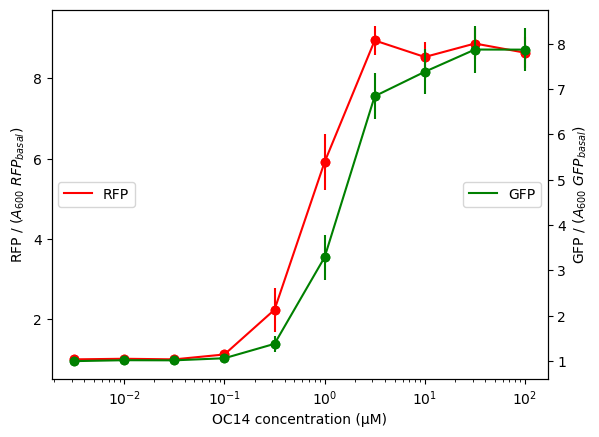

In [27]:
OC14_list = np.logspace(-2.5,2,10)
gfpReplicates = pd.DataFrame()
rfpReplicates = pd.DataFrame()


output_df = pd.read_excel(subcircuit1_excelpath)

#find maximum od values
od600Max, gfpMax, rfpMax, maxValueIndex = maxgrowth_data(output_df)
replicate_indices = [(['B11', 'B10', 'B9', 'B8', 'B7', 'B6', 'B5', 'B4', 'B3', 'B2'],['C11', 'C10', 'C9', 'C8', 'C7', 'C6', 'C5', 'C4', 'C3', 'C2']),
                        (['D11', 'D10', 'D9', 'D8', 'D7', 'D6', 'D5', 'D4', 'D3', 'D2'],['E11', 'E10', 'E9', 'E8', 'E7', 'E6', 'E5', 'E4', 'E3', 'E2']),
                        (['F11', 'F10', 'F9', 'F8', 'F7', 'F6', 'F5', 'F4', 'F3', 'F2'],['G11', 'G10', 'G9', 'G8', 'G7', 'G6', 'G5', 'G4', 'G3', 'G2'])]
#relativise to od600
for fluorophoreData, fluorophoreName in zip([gfpMax, rfpMax], ['GFP', 'RFP']):
    # relFp = fluorophoreData/od600Max

    relFp = fluorophoreData


    for repIndex in replicate_indices:
        rep = (relFp[repIndex[0]], relFp[repIndex[1]])

        intraexperiment_mean = pd.Series(np.mean(np.stack(rep), axis=0))
        if fluorophoreName == 'GFP':
            gfpReplicates = gfpReplicates.append(intraexperiment_mean, ignore_index=True)
        elif fluorophoreName == 'RFP':
            rfpReplicates = rfpReplicates.append(intraexperiment_mean, ignore_index=True)



#define columns as OC14 concentrations
gfpReplicates.columns = OC14_list
rfpReplicates.columns = OC14_list

#average interexperimental replicates 
meanGfp = gfpReplicates.mean(axis=0)
meanGfp_basal = meanGfp/np.amin(meanGfp)
stdGfp = gfpReplicates.std(axis=0)
stdGfp_basal = stdGfp/np.amin(meanGfp)

meanRfp = rfpReplicates.mean(axis=0)
meanRfp_basal = meanRfp/np.amin(meanRfp)
stdRfp = rfpReplicates.std(axis=0)
stdRfp_basal = stdRfp/np.amin(meanRfp)

plotDoseResponsevsData(OC14_list, meanRfp_basal, meanGfp_basal, stdRfp_basal ,stdGfp_basal, inducerName='OC14') 


In [28]:
dataDict = {}
dataDict['OC14'] = OC14_list
dataDict['mean_gfp'] = meanGfp_basal
dataDict['std_gfp'] = stdGfp_basal
dataDict['mean_rfp'] = meanRfp_basal
dataDict['std_rfp'] = stdRfp_basal
pkl.dump(dataDict, open('input/liquid_culture/curatedData/Jure_subcircuit3_circuit14_doseResponseOC14_0.5ATC.pkl', 'wb'))
